# 1) TASK1.1 : PCA from scratch

In [1]:
from sklearn import datasets

from matplotlib import pyplot as plt

%matplotlib inline

In [2]:
iris = datasets.load_iris()
X = iris.data  # we only take the first two features.
y = iris.target


## Standardizing

Перед разложением, как правило центрируют данные, чтобы признаки имели среднее=0 (иногда и дисперсию=1)

Сделаем это

In [3]:
from sklearn.preprocessing import StandardScaler
X_std = StandardScaler().fit_transform(X)


## 1 - Eigendecomposition - Вычисление собственных векторов и собственных значений

Основная идея PCA - разложение матрицы ковариации исхордных данных. Собственные вектора (eigenvectors) еще называются главными компонентами, поэтому метод еще называется "Методом Главных Компонент".

Собственные вектора определяют направления в новом пространстве признаков, а собственные числа(eigenvalues) - их амплитуду. Другмими словами, собственные значения показывают дисперсию данных вдоль конкретного направления, заданного собственным вектором.

### Вычисление ковариационной матрицы

In [4]:
## Собственно посчитаем матрицу ковариации

import numpy as np

# так как мы уже нормализовали данные, то нет смысла вычитать из столбцов среднее значение признаков
# но если бы мы этого не сделали, то нужно было бы сделать так:
# mean_vec = np.mean(X_std, axis=0)
# cov_mat = (X_std - mean_vec).T.dot((X_std - mean_vec)) / (X_std.shape[0]-1)

cov_mat = X_std.T.dot(X_std) / (X_std.shape[0]-1)

print('Covariance matrix \n%s' %cov_mat)

## и сравним с матрицей, вычисленной в numpy

print('\nNumPy covariance matrix: \n%s' %np.cov(X_std.T))

print ('\nError: ', (cov_mat - np.cov(X_std.T)).sum()/cov_mat.size)

Covariance matrix 
[[ 1.00671141 -0.11010327  0.87760486  0.82344326]
 [-0.11010327  1.00671141 -0.42333835 -0.358937  ]
 [ 0.87760486 -0.42333835  1.00671141  0.96921855]
 [ 0.82344326 -0.358937    0.96921855  1.00671141]]

NumPy covariance matrix: 
[[ 1.00671141 -0.11010327  0.87760486  0.82344326]
 [-0.11010327  1.00671141 -0.42333835 -0.358937  ]
 [ 0.87760486 -0.42333835  1.00671141  0.96921855]
 [ 0.82344326 -0.358937    0.96921855  1.00671141]]

Error:  -1.1449174941446927e-16


### Сейчас найдем собственные вектора ковариационной матрицы



In [5]:
cov_mat = np.cov(X_std.T)

eig_vals, eig_vecs = np.linalg.eig(cov_mat)

print('Eigenvectors \n%s' %eig_vecs)
print('\nEigenvalues \n%s' %eig_vals)

Eigenvectors 
[[ 0.52237162 -0.37231836 -0.72101681  0.26199559]
 [-0.26335492 -0.92555649  0.24203288 -0.12413481]
 [ 0.58125401 -0.02109478  0.14089226 -0.80115427]
 [ 0.56561105 -0.06541577  0.6338014   0.52354627]]

Eigenvalues 
[2.93035378 0.92740362 0.14834223 0.02074601]


### Singular Vector Decomposition

Хотя вычисление собственных векторов и собственных чисел ковариационной матрицы - более интуитивный способ получения главных компонент, большинство реализаций PCA под капотом выполняют SVD (более эвычислительно эффективно).

Так что давайте сделаем еще и SVD, и убедимся, что результаты получатся те ми же самыми

In [6]:
v,sigma,u = np.linalg.svd(X_std.T)
v

array([[-0.52237162, -0.37231836,  0.72101681,  0.26199559],
       [ 0.26335492, -0.92555649, -0.24203288, -0.12413481],
       [-0.58125401, -0.02109478, -0.14089226, -0.80115427],
       [-0.56561105, -0.06541577, -0.6338014 ,  0.52354627]])

In [9]:
sigma

array([20.89551896, 11.75513248,  4.7013819 ,  1.75816839])

## 2 - Selecting Principal Components

Цель PCA - снижение размерности путем проекции данных на направления, задаваемые собственными векторами. Они задают только направление и их длина 1, в чем и убедимся:

In [10]:
for ev in eig_vecs:
    np.testing.assert_array_almost_equal(1.0, np.linalg.norm(ev))
print('Everything ok!')


Everything ok!


Чтобы определиться, куда проецировать данные нужно упорядочить собственные вектора в соответствии со значением собственных чисел. Вектора с наименьшими собственными числами наименее информативны, и могут быть выброшены из рассмотрения

In [11]:
# Make a list of (eigenvalue, eigenvector) tuples
eig_pairs = [(np.abs(eig_vals[i]), eig_vecs[:,i]) for i in range(len(eig_vals))]

# Sort the (eigenvalue, eigenvector) tuples from high to low
eig_pairs.sort()
eig_pairs.reverse()

# Visually confirm that the list is correctly sorted by decreasing eigenvalues
print('Eigenvalues in descending order:')
for i in eig_pairs:
    print(i[0])


Eigenvalues in descending order:
2.930353775589319
0.9274036215173421
0.14834222648163983
0.02074601399559602


После сортировки нужно определиться с количеством новых признаков. Обычно используют "explained variance", которая показывает, какое количество дисперсии в данных описывается конкретной компонентой

In [12]:
tot = sum(eig_vals)
var_exp = [(i / tot)*100 for i in sorted(eig_vals, reverse=True)]
cum_var_exp = np.cumsum(var_exp)

cum_var_exp

array([ 72.77045209,  95.80097536,  99.48480732, 100.        ])

In [13]:
var_exp

[72.77045209380135, 23.030523267680643, 3.6838319576273855, 0.515192680890634]

Первая главная компонента описывает 72.77% дисперсии данных, первые две - 95.8%, первые три - 99.48%  

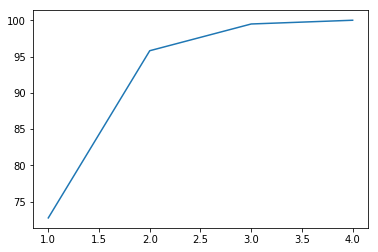

In [14]:
plt.plot(range(1, len(eig_pairs)+1), cum_var_exp)

Обычно если из решаемой задачи нет понимания, сколько компонент нужно оставить (например, какой размер вектора сущности нужно получить, если PCA нужен для получения "эмбеддингов"), то следует выбирать такое количество главных компонент, которе описывает не менее 99% дисперсии данных

То есть в нашем случае хватит 3х главных компонент

Но давайте попробуем сузить до 2х, чтобы отрисовать данные на плоскости, так как PCA часто используется для визуализации данных

In [15]:
matrix_w = np.hstack((eig_pairs[0][1].reshape(4,1), 
                      eig_pairs[1][1].reshape(4,1)))

print('Matrix W:\n', matrix_w)  # truncated matrix 

Matrix W:
 [[ 0.52237162 -0.37231836]
 [-0.26335492 -0.92555649]
 [ 0.58125401 -0.02109478]
 [ 0.56561105 -0.06541577]]


## 3 - Проекция данных  в новове признаковое пространство


In [16]:
X_proj = X_std.dot(matrix_w)

Давайте посмотрим, как данные спроектировались на плоскость

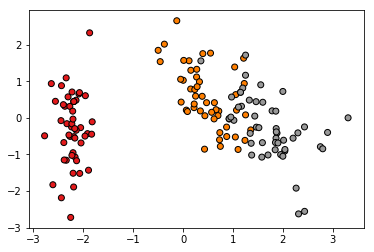

In [17]:
plt.scatter(X_proj[:, 0], X_proj[:, 1], c=y, cmap=plt.cm.Set1,
            edgecolor='k')

## 4 - PCA in scikit-learn 

а теперь воспользуемся мощью компутера и пусть scikit-learn нам сам все посчитает

In [18]:
from sklearn.decomposition import PCA as sklearnPCA
sklearn_pca = sklearnPCA(n_components=2)
X_proj_sklearn = sklearn_pca.fit_transform(X_std)

In [19]:
print ('\nError: ', (X_proj_sklearn - X_proj).sum()/X_proj.size)


Error:  8.289665250534503e-17


----------------------------------------------------------------------------------------------------------------------

# 2) TASK1.2: Рекомендательные системы и SVD разложение

Чтоо такое SVD? Это алгоритм, который аппроксимирует матрицу $R$ наилучшим способом путем разложения на 3 матрицы $V$, $\Sigma$ , $U^{T}$

$$\begin{equation}
R = V\Sigma U^{T}
\end{equation}$$

где 
- $R$ - матрица оценок пользователей различным фильмам (user-rating), 

- $V$ - матрица "пользователь - скрытые переменные". Эти  скрытые переменные (если интуитивно) могут отражать какие-то характеристики фильма. Например, одной из таких характеристик может быть жанр. Матрица $V$ показывает, насколько пользователю нравятся те или иные характеристики фильма, неявно выраженные через разложение. Заметим, что количество скрытых переменных - это и есть то количество компонент, которое мы хотим взять для аппроксимации исходной матрицы.
 
- $\Sigma$  - диагональная матрица, на главной диагонали которой стоят квадраты собственных чисел матрицы $R^TR$. Интуитивно показывает веса того, насколько важна та или иная скрытая переменная

- $U^{T}$ - матрица "фильм - скрытые переменные". Показывает, насколько тот или иной фильм отражает ту или иную скрытую переменную. Например, вес компонента, отражающий принадлежность фильма "Эйс Вентура: розыск домашних животных" к скрытому признаку "Жанр - триллер" - будет невелик.


Помним, что мы можем получить полное разложение и восттановить исходную матрицу обратно, но нам это неинтересно. Давайте возьмем топ $k$ комонент для разложения.

In [20]:
# Загрузим данные
import pandas as pd
import numpy as np

ratings_list = [i.strip().split("::") for i in open('data/ml-1m/ratings.dat', 'r').readlines()]
users_list = [i.strip().split("::") for i in open('data/ml-1m/users.dat', 'r').readlines()]
movies_list = [i.strip().split("::") for i in open('data/ml-1m/movies_enc.dat', 'r').readlines()]

In [21]:
ratings = np.array(ratings_list)
users = np.array(users_list)
movies = np.array(movies_list)

In [22]:
ratings_df = pd.DataFrame(ratings_list, columns = ['UserID', 'MovieID', 'Rating', 'Timestamp'], dtype = int)
movies_df = pd.DataFrame(movies_list, columns = ['MovieID', 'Title', 'Genres'])
movies_df['MovieID'] = movies_df['MovieID'].apply(pd.to_numeric)

Взлгянем на формат данных

In [23]:
movies_df.head()

,MovieID,Title,Genres
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama
4,5,Father of the Bride Part II (1995),Comedy


In [24]:
ratings_df.head()

,UserID,MovieID,Rating,Timestamp
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291


Сведем две таблицы в одну, чтобы по строкам были пользователи, по столбцам - фильмы, а на пересечении - оценка пользователя фильму.
Если этот фильм не оценивался пользователем - заполним нулем.

In [25]:
R_df = ratings_df.pivot(index = 'UserID', columns ='MovieID', values = 'Rating').fillna(0)
R_df.head()

MovieID,1,2,3,4,5,6,7,8,9,10,...,3943,3944,3945,3946,3947,3948,3949,3950,3951,3952
UserID,,,,,,,,,,,,,,,,,,,,,
1,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Как правило, перед применением SVD и PCA данные надо центрировать

Давайте нормализуем матрицу per-user, вычтя для каждого пользователя среднее всех его оценок для фильма

In [26]:
R = R_df.as_matrix()
user_ratings_mean = np.mean(R, axis = 1)  # mean per user
R_demeaned = R - user_ratings_mean.reshape(-1, 1)

/Users/alexander/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """Entry point for launching an IPython kernel.


## Singular Value Decomposition


Будем использовать ф-ю scipy `svds` для svd разложения. Выберем 50 компонент


In [27]:
%%time
from scipy.sparse.linalg import svds
V, sigma, Ut = svds(R_demeaned, k=50)

CPU times: user 6.46 s, sys: 28.9 ms, total: 6.49 s
Wall time: 1.66 s


In [28]:
V.shape, sigma.shape, Ut.shape

((6040, 50), (50,), (50, 3706))

$\Sigma$ - вернулся как вектор квадратов собственных чисел. Давайте сконвертим его в диагональную матрицу

In [29]:
sigma = np.diag(sigma)
sigma.shape

(50, 50)

## Получим аппроксимированное значение матрицы $R$ для матрицы с рекомендациями

In [30]:
all_user_predicted_ratings = np.dot(np.dot(V, sigma), Ut)
all_user_predicted_ratings += user_ratings_mean.reshape(-1, 1) # вернем обратно средние оценки per-user
all_user_predicted_ratings -= all_user_predicted_ratings.min(axis=1).reshape(-1, 1)  # пусть не будет отрицательных оценок (начинаются от 0)

In [31]:
predicted_ratings_shifted = []
for user_ratings in all_user_predicted_ratings:
    if user_ratings.max() > 5:
        user_ratings /= user_ratings.max()*5
    
    predicted_ratings_shifted.append(user_ratings)
predicted_ratings_shifted = np.array(predicted_ratings_shifted)

По-хорошему, количество компонент не выбирается вслепую. Необходимо разделить данные на train и valid, и оптимизировать RMSE(predicted, true) на валидационном наборе данных, таким образом подобрав оптимальное значение $k$

## Попробуем порекомендовать что-нибудь кому-нибудь

Давайте сделаем предсказания для конкретного пользователя. Среди тех фильмов, для которых нет оценок у данного пользователя, выведем топ фильмов с максимальным предсказанным рейтингом.

In [32]:
preds_df = pd.DataFrame(all_user_predicted_ratings, columns = R_df.columns)
preds_df.head()

MovieID,1,2,3,4,5,6,7,8,9,10,...,3943,3944,3945,3946,3947,3948,3949,3950,3951,3952
0,4.776419,0.630613,0.292479,0.468716,0.499790,0.310955,0.413438,0.628916,0.428005,0.291608,...,0.515365,0.489198,0.513954,0.465535,0.402143,0.891087,0.593137,0.519470,0.538008,0.576469
1,0.053726,0.035462,0.040726,0.030097,0.030787,0.073047,0.031707,0.032337,0.035206,0.079850,...,0.028279,0.029637,0.029737,0.032061,0.029557,0.035021,0.016774,0.026862,0.028355,0.025621
2,0.099529,0.046134,0.031826,0.026575,0.027254,0.022046,0.023098,0.032139,0.029458,0.057079,...,0.029847,0.028054,0.028764,0.029411,0.029079,0.033023,0.031247,0.028745,0.028855,0.023953
3,0.913736,0.432719,0.545322,0.595042,0.547629,0.743432,0.456253,0.515146,0.551148,0.394309,...,0.514250,0.500254,0.497179,0.502263,0.421698,0.600192,0.563236,0.479629,0.520520,0.471455
4,0.088216,0.037505,0.035137,0.044873,0.035754,0.087498,0.030294,0.036325,0.034837,0.051522,...,0.040409,0.038314,0.037038,0.036291,0.035177,0.035096,0.053373,0.037917,0.040917,0.043318


In [33]:
def get_users_ratings_history(userID, original_ratings_df, movies_df):
     # Get the user's data and merge in the movie information.
    user_data = original_ratings_df[original_ratings_df.UserID == (userID)]
    user_full = (user_data.merge(movies_df, how = 'left', left_on = 'MovieID', right_on = 'MovieID').
                     sort_values(['Rating'], ascending=False))
    return user_full

In [34]:
def recommend_movies(userID, preds_df, movies_df, user_history, original_ratings_df, num_recommendations=10):
    user_row_number = userID - 1 # UserID starts at 1, not 0
    sorted_user_predictions = preds_df.iloc[user_row_number].sort_values(ascending=False)
    sorted_user_predictions = pd.DataFrame(sorted_user_predictions).reset_index()
    sorted_user_predictions = sorted_user_predictions.rename(columns={user_row_number : "Score"})
    
    not_rated_for_user = movies_df[~movies_df['MovieID'].isin(user_history['MovieID'])]
    full_not_rated_predictions = not_rated_for_user.merge(sorted_user_predictions, how = 'left', left_on = 'MovieID', right_on = 'MovieID')
    full_not_rated_predictions = full_not_rated_predictions.sort_values('Score', ascending = False)
    top_best_rated_predictions = full_not_rated_predictions.iloc[:num_recommendations, :-1]
    return top_best_rated_predictions

## Посмотрим, каким кино интересуется пользователь с номером 837 и порекомендуем ему что-нибудь

In [35]:
user_id = 837

In [36]:
user_history = get_users_ratings_history(user_id, ratings_df, movies_df)
user_history[:10]

,UserID,MovieID,Rating,Timestamp,Title,Genres
36,837,858,5,975360036,"Godfather, The (1972)",Action|Crime|Drama
35,837,1387,5,975360036,Jaws (1975),Action|Horror
65,837,2028,5,975360089,Saving Private Ryan (1998),Action|Drama|War
63,837,1221,5,975360036,"Godfather: Part II, The (1974)",Action|Crime|Drama
11,837,913,5,975359921,"Maltese Falcon, The (1941)",Film-Noir|Mystery
20,837,3417,5,975360893,"Crimson Pirate, The (1952)",Adventure|Comedy|Sci-Fi
34,837,2186,4,975359955,Strangers on a Train (1951),Film-Noir|Thriller
55,837,2791,4,975360893,Airplane! (1980),Comedy
31,837,1188,4,975360920,Strictly Ballroom (1992),Comedy|Romance
28,837,1304,4,975360058,Butch Cassidy and the Sundance Kid (1969),Action|Comedy|Western


In [37]:
recommend_movies(user_id, preds_df, movies_df, user_history, ratings_df, 10)

,MovieID,Title,Genres
516,527,Schindler's List (1993),Drama|War
1848,1953,"French Connection, The (1971)",Action|Crime|Drama|Thriller
596,608,Fargo (1996),Crime|Drama|Thriller
1235,1284,"Big Sleep, The (1946)",Film-Noir|Mystery
2085,2194,"Untouchables, The (1987)",Action|Crime|Drama
1188,1230,Annie Hall (1977),Comedy|Romance
1198,1242,Glory (1989),Action|Drama|War
897,922,Sunset Blvd. (a.k.a. Sunset Boulevard) (1950),Film-Noir
1849,1954,Rocky (1976),Action|Drama
581,593,"Silence of the Lambs, The (1991)",Drama|Thriller


Выглядит неплохо!

Хотя мы вообще не использовали такие признаки, как жанр фильма, модель смогла ухватить эти признаки в качестве скрытых, и предложить пользователю похожее кино по его вкусу.

## А давайте еще посмотрим, что у нас скрывается внутри матрицы $U$

Как мы знаем, матрица $U$ хранит вектора для фильмов.

Поищем фильмы, вектора которых являются ближайшими по евклидову расстоянию к тому фильму, айдишник которого мыф передадим в качестве запроса

In [47]:
def get_closest_movies(movie_id, Ut, R_df, top=10):
    print(movies_df[movies_df.MovieID == movie_id])
    
    U = Ut.transpose()
    vec = U[movie_id-1]  # movie_is starts from 1
    vec_ = np.array([vec for _ in range(U.shape[0])])
    diff = ((U - vec_) ** 2).sum(axis=1)
    
    diff = np.sqrt(diff)
    closest_movie_idx = np.argsort(diff)[1:top+1]  # не берем первый элемент, потому что это тот же самый фильм
    true_idx = R_df.columns[closest_movie_idx]
    closest_movies = pd.DataFrame(true_idx)
    closest_movies = closest_movies.merge(movies_df, left_on="MovieID", right_on="MovieID")
    print("--------------")

    print("Closest movies")
    print(closest_movies)
    

In [48]:
get_closest_movies(1, Ut, R_df, 10)

   MovieID             Title                       Genres
0        1  Toy Story (1995)  Animation|Children's|Comedy
--------------
Closest movies
   MovieID                                Title  \
0     3114                   Toy Story 2 (1999)   
1       34                          Babe (1995)   
2     2355                 Bug's Life, A (1998)   
3     2321                 Pleasantville (1998)   
4     2384         Babe: Pig in the City (1998)   
5     2687                        Tarzan (1999)   
6      588                       Aladdin (1992)   
7     3157                 Stuart Little (1999)   
8     3255        League of Their Own, A (1992)   
9     1923  There's Something About Mary (1998)   

                                Genres  
0          Animation|Children's|Comedy  
1              Children's|Comedy|Drama  
2          Animation|Children's|Comedy  
3                               Comedy  
4                    Children's|Comedy  
5                 Animation|Children's  
6  An

Похоже на что-то осмысленное!

Здорово, что SVD вообще никак не используя информацию о жанре, научился группировать похожие фильмы. 

Как это стало возможно?

### Задания
1) Реализуйте поиск ближайших по косинусному расстоянию векторов (обычно вектора сравнивают именно так).  Отличаются ли результаты?

2) Выполните поиск ближайших (по евклидовой метрике) 5 пользователей к заданному пользователю с user_id = 837. Для пользователя с каким user_id у пользователя с user_id=837 больше всего общих фильмов, оцененных на 5?